In [1]:
import matplotlib

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
%config InlineBackend.rc = {'figure.figsize': (12, 8)}

from matplotlib import pyplot as plt
from matplotlib import cm

import numpy as np
import numexpr as ne
import time

import lalsimulation as lalsim
import lal
#import bayespputils as bppu

import emcee
import triangle

from  scipy.stats import truncnorm

A Morlet-Gabor wavelet (sinegaussian) is characterized by a central time and frequency $t_0,\ f_0$, a duration $\tau_{sg} = Q/{2\pi f_0}$ (where $Q$ is the dimensionless quality factor), an amplitude $A$ and a phase offset $\phi_0$

Below are given expressions for sinegaussians in both time

$$\Psi(t; A, f_0, Q, t_0, \phi_0) = A e^{-(t-t_0)^2/\tau_{sg}^2} \cos(2 \pi f_0(t-t_0) + \phi_0)$$

and frequency domain,

$$\Psi(f; A, f_0, Q, t_0, \phi_0) = \frac{\sqrt{\pi} A\tau_{sg} }{2} e^{-\pi^2 \tau_{sg}^2 (f-f_0)^2}\left(e^{i(\phi_0+2\pi(f-f_0)t_0)} + e^{-i(\phi_0+2\pi(f+f_0)t_0)} e^{-Q^2 f /f_0}\right)$$

taken from Cornish & Littenberg (2015) [arXiv:1410.3835](http://arxiv.org/abs/1410.3835) (eqns. 4&5)

In [343]:
def sinegaussian_t(t, t_0, f_0, tau_sg, A=1., phi_0=0.):
    return A*np.exp(-np.square(t-t_0)/np.square(tau_sg))*np.cos(2.*np.pi*f_0*(t-t_0) + phi_0)

def sinegaussian_f(f, t_0, f_0, tau_sg, A=1., phi_0=0.):
    #tau_sg = Q/(2.*np.pi*f_0)
    Q = tau_sg*2.*np.pi*f_0
    Amplitude = 0.5*np.sqrt(np.pi)*A*tau_sg
    return Amplitude*np.exp(-np.square(np.pi*tau_sg*(f - f_0)))*\
                    (np.exp(1j*(phi_0 + 2.*np.pi*(f - f_0)*t_0)) + \
                     (np.exp(-1j*(phi_0 + 2.*np.pi*(f + f_0)*t_0))*np.exp(-np.square(Q)*f/f_0)))
    
def sinegauusian_f(f, t_0, f_0, tau_sg, A=1., phi_0=0.):
    Q = tau_sg*2.*np.pi*f_0
    Amplitude = 0.5*np.sqrt(np.pi)*A*tau_sg
    
    
#print np.exp(1j*(phi_0 + 2.*np.pi*(fseries - f_0)*t_0))

In [400]:
dt = 1/512.
timeseries = np.arange(-1.,1,dt)
#dt = timeseries[1] - timeseries[0]
total_time = timeseries[-1] - timeseries[0]

len_t = timeseries.shape[0]

freq_max = 0.5/dt
freq_len = 0.5*timeseries.shape[0] + 1
df = 1/total_time
fseries = np.linspace(df, freq_max, freq_len)

len_f = fseries.shape[0]



print df

print timeseries.shape

print fseries.shape
#print timeseries

print fseries[-1], freq_max

0.500488758553
(1024,)
(513,)
256.0 256.0


(1024,) (513,)


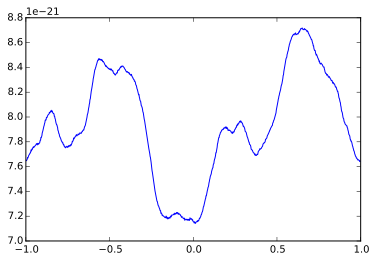

In [403]:
PSD = np.zeros(fseries.shape[0])
for i in xrange(fseries.shape[0]):
        PSD[i] = lalsim.SimNoisePSDaLIGOZeroDetHighPower(fseries[i])
        
ASD = np.sqrt(PSD)

white_t_noise = np.random.normal(0, 1, timeseries.shape[0])
white_f_noise = np.fft.rfft(white_t_noise)

print white_t_noise.shape, white_f_noise.shape

#print white_f_noise

coloured_f_noise = ASD*white_f_noise
coloured_t_noise = np.fft.irfft(coloured_f_noise, len_t)#/len_f

#print coloured_t_noise - white_t_noise
#print time_noise.sum()

plt.plot(timeseries,coloured_t_noise)
plt.show()

Parameters in sample data

t_0 = 0.03
f_0 = 19.0
A = 6e-22
phi_0 = 0.0

Q = 30

In [404]:
t_0 = 0.03
f_0 = 19.0
#tau_sg = 8.4
A = 6e-22
phi_0 = 0.0

Q = 30
#tau_sg*2.*np.pi*f_0

tau_sg = Q/(2.*np.pi*f_0)

print 'Q', Q, tau_sg
print A*np.sqrt(Q)/np.sqrt(2*np.sqrt(2*np.pi)*f_0*(A*A/4))


sg_t = sinegaussian_t(timeseries, t_0, f_0, tau_sg, A, phi_0)
sg_f = sinegaussian_f(fseries, t_0, f_0, tau_sg, A, phi_0)

sg_t_max = sg_t.max()
print sg_t_max



Q 30 0.251297278566
1.12241602251
5.97882811831e-22


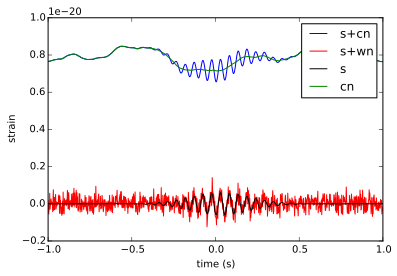

In [405]:
plt.plot(timeseries, sg_t + coloured_t_noise, label='s+cn', c='b')
plt.plot(timeseries, sg_t + white_t_noise*A/2, label='s+wn', c='r' )
plt.plot(timeseries, sg_t, label='s', c='k' )
plt.plot(timeseries, coloured_t_noise, label='cn',c='g')
plt.ylabel('strain')
plt.xlabel('time (s)')
plt.legend(loc='upper right')
plt.show()



-8.82526937398


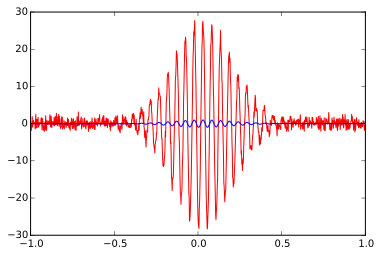

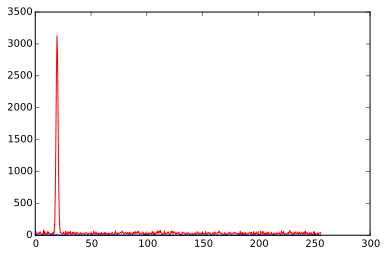

1024 513.0


In [457]:
pre_whitened_f_data = np.fft.rfft(sg_t + coloured_t_noise)#/(np.sqrt(2))#*fseries)
whitened_f_data = pre_whitened_f_data/ASD

white_t_data = sg_t + white_t_noise*A/2

white_f_data = np.fft.rfft(white_t_data)

whitened_t_data = np.fft.irfft(whitened_f_data)

print ((sg_t/A)/np.fft.irfft(whitened_f_data/freq_len))[len_t/2:3*len_t/2].mean()

white_ASD = np.ones_like(ASD)*A/2
white_PSD = np.square(white_ASD)

plt.plot(timeseries, whitened_t_data, c='r')
plt.plot(timeseries, sg_t/A , c='b')
#plt.ylim(-2, 2)
plt.show()

plt.plot(fseries, np.absolute(whitened_f_data), c='r')#/np.sqrt(len_f)
#plt.plot(fseries, np.absolute(np.fft.fftshift(white_f_data/freq_len)), c='r')
#plt.plot(fseries, np.absolute(np.fft.fftshift(np.fft.rfft(sg_t)/freq_len)), c='g')
plt.plot(fseries, np.absolute(sg_f)/ASD , c='b')
#plt.ylim(0,1e-21)
plt.show()

#print white_f_data, sg_f

print len_t, freq_len

In [445]:
np.savetxt('timeseries.dat', timeseries)
np.savetxt('freqseries.dat', fseries)
np.savetxt('PSD.dat', PSD)
np.savetxt('coloured_data.dat', (sg_t + coloured_t_noise))
np.savetxt('whitened_t_data.dat', whitened_t_data)

In [446]:
f_lim = [1, 32]
t_lim = [0.01, 0.05]


def logpost(samp_par, freq_data, f, tau_sg, A, phi_0, PSD,df):
    t_0 = samp_par[1]
    f_0 = samp_par[0]
    if t_0 < t_lim[0] or t_0 > t_lim[1]:
        return -np.inf
    elif f_0 < f_lim[0] or f_0 > f_lim[1]:
        return -np.inf
    else:
        #thing = (freq_data - sinegaussian_f(f, t_0, f_0, tau_sg, A, phi_0))
        thing = (freq_data - np.fft.fftshift(sinegaussian_f(f, t_0, f_0, tau_sg, A, phi_0)))
    
        return 4.*((thing*np.conj(thing)*df/PSD).sum()).real


In [355]:
nthreads = 4
nwalkers = int(nthreads*100)
ndim = 2
nburnin = 400
nsteps = int(nburnin*3)

pos00 = np.ones([nwalkers,ndim]) + 1e-3*np.random.randn(nwalkers, ndim)

f_mean = np.mean(f_lim)
f_sigma = np.sum(np.abs(f_lim))/4
t_mean = np.mean(t_lim)
t_sigma = np.sum(np.abs(t_lim))/4

f_0_0 = np.random.uniform(f_lim[0], f_lim[1], nwalkers)
#f_0_0 = truncnorm.rvs((f_lim[0]/2. - f_mean)/f_sigma , (f_lim[1]/2. - f_mean)/f_sigma, \
#loc=f_mean, scale=f_sigma, size=nwalkers)
t_0_0 = truncnorm.rvs((t_lim[0] - t_mean)/t_sigma , (t_lim[1] - t_mean)/t_sigma, \
loc=t_mean, scale=t_sigma, size=nwalkers)

pos0 = np.vstack((f_0_0,t_0_0)).T

print np.sqrt((sg_f*np.conj(sg_f)*df/white_PSD).sum()).real

print pos00.shape, pos0.shape

print 4.4*2*np.pi

print t_0_0.min(), t_0_0.max()
print f_0_0.min(), f_0_0.max()

#print pos0[:,0].max()

0.562031904056
(400, 2) (400, 2)
27.6460153516
-0.0993085779271 0.0987315218874
1.00428610533 31.9681504923


I have initialised stuff
I have finished sampling
ac for dataset is  [ 29.65259658  20.81847299]


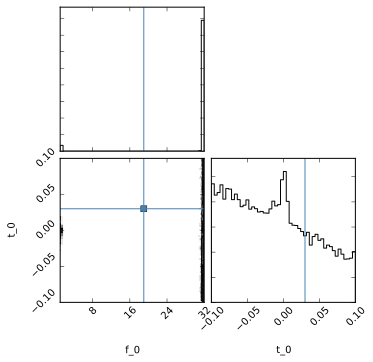

In [444]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, logpost, \
                                args=[pre_whitened_f_data/np.sqrt(len_f), fseries, tau_sg, A, phi_0, PSD, df], \
                                threads=nthreads)

pos, prob, state = sampler.run_mcmc(pos0, nburnin, storechain=False)
print "I have initialised stuff"

sampler.reset()

sampler.run_mcmc(pos, nsteps)
print "I have finished sampling"
#print rates_reveal[rates_index]

#sam_flatchain = sampler.flatchain
act = sampler.acor
act_max = int(np.amax(act))

print 'ac for dataset is ', act

#print sampler.flatchain

fig = triangle.corner(sampler.flatchain[0:len(sampler.flatchain):act_max,:], \
                      labels=['f_0','t_0'], truths=[f_0,t_0])
fig.show()


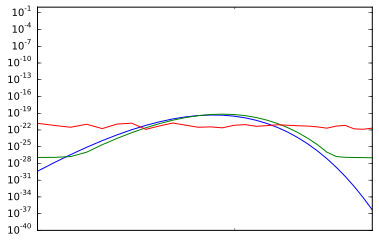

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in divide


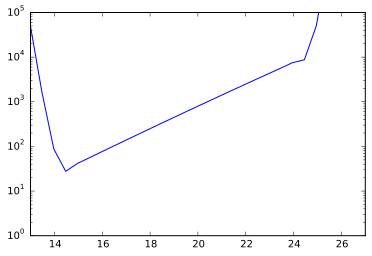

In [416]:
fftf = np.fft.rfftfreq(sg_t.shape[0], dt)

#print fftf - fseries


#plt.plot(fseries, sg_f+coloured_f_noise)
plt.plot(fseries, np.absolute(sg_f)*np.square(fseries))
plt.plot(fseries, np.absolute(np.fft.rfft(sg_t)))
plt.plot(fseries, np.absolute(coloured_f_noise))
plt.xscale('log')
plt.yscale('log')
plt.xlim(13, 27)
plt.ylim(1e-40, 1)
plt.show()

plt.plot(fseries, np.absolute(np.fft.rfft(sg_t))/np.absolute(sg_f))
#plt.xscale('log')
plt.yscale('log')
plt.xlim(13, 27)
plt.ylim(1, 1e5)
plt.show()

1024 256.0


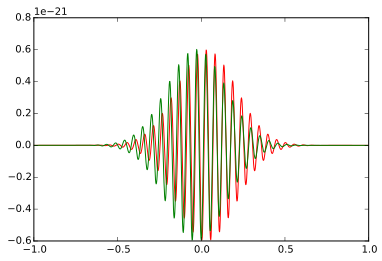

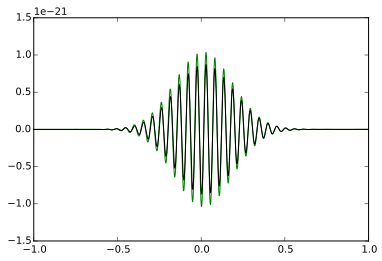

In [340]:
rrr = timeseries.shape[0]
print rrr, fseries[-1]

#plt.plot(fseries, sg_f+coloured_f_noise)
plt.plot(timeseries, sg_t, c='r')
plt.plot(timeseries, -np.fft.ifftshift(np.fft.irfft(len_f*sg_f)), c='g')
#plt.plot(fseries, coloured_f_noise)
#plt.xscale('log')
#plt.yscale('log')
#plt.ylim(1e-40, 1)
plt.show()

plt.plot(timeseries, sg_t - rrr*np.fft.ifftshift(np.fft.irfft(sg_f))/np.sqrt(2*np.pi), c='g')
plt.plot(timeseries, sg_t - fseries[-1]*np.fft.ifftshift(np.fft.irfft(sg_f)), c='k')
#plt.plot(fseries, coloured_f_noise)
#plt.xscale('log')
#plt.yscale('log')
#plt.ylim(1e-40, 1)
plt.show()